In [1]:
from utils.hparams import hparams
from preprocessing.data_gen_utils import get_pitch_parselmouth,get_pitch_crepe
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import utils
import librosa
import torchcrepe
from infer import *
import logging
from infer_tools.infer_tool import *

logging.getLogger('numba').setLevel(logging.WARNING)

# 工程文件夹名，训练时用的那个
project_name = "nyaru"
model_path = f'./checkpoints/{project_name}/model_ckpt_steps_112000.ckpt'
config_path=f'./checkpoints/{project_name}/config.yaml'
hubert_gpu=True
svc_model = Svc(project_name,config_path,hubert_gpu, model_path)
print('model loaded')

e:\Software\Anaconda3\envs\diffsvc\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


| load 'model' from './checkpoints/nyaru/model_ckpt_steps_112000.ckpt'.
| load 'model' from 'checkpoints/0102_xiaoma_pe/model_ckpt_steps_60000.ckpt'.
| load HifiGAN:  checkpoints/0109_hifigan_bigpopcs_hop128\model_ckpt_steps_1512000.pth
| Loaded model parameters from checkpoints/0109_hifigan_bigpopcs_hop128\model_ckpt_steps_1512000.pth.
| HifiGAN device: cuda.
model loaded


In [4]:
wav_fn='raw/test_input.wav'#支持多数音频格式，无需手动转为wav
demoaudio, sr = librosa.load(wav_fn)
key = 0  # 音高调整，支持正负（半音）
# 加速倍数
pndm_speedup = 20
wav_gen='test_output.wav'#直接改后缀可以保存不同格式音频，如flac可无损压缩
f0_tst, f0_pred, audio = run_clip(svc_model,file_path=wav_fn, key=key, acc=pndm_speedup, use_crepe=True, use_pe=True, thre=0.05,
                                        use_gt_mel=False, add_noise_step=500,project_name=project_name,out_path=wav_gen)

load chunks from temp
#=====segment start, 0.46s======
jump empty segment
#=====segment start, 6.702s======
load temp crepe f0
executing 'get_pitch' costed 0.066s
hubert (on cpu) time used 0.6847963333129883


sample time step: 100%|██████████| 50/50 [00:02<00:00, 21.95it/s]


executing 'diff_infer' costed 2.310s
executing 'after_infer' costed 1.167s
#=====segment start, 8.831s======
load temp crepe f0
executing 'get_pitch' costed 0.063s
hubert (on cpu) time used 0.8832910060882568


sample time step: 100%|██████████| 50/50 [00:02<00:00, 18.36it/s]


executing 'diff_infer' costed 2.749s
executing 'after_infer' costed 1.894s
#=====segment start, 5.265s======
load temp crepe f0
executing 'get_pitch' costed 0.065s
hubert (on cpu) time used 0.5448079109191895


sample time step: 100%|██████████| 50/50 [00:01<00:00, 28.39it/s]


executing 'diff_infer' costed 1.780s
executing 'after_infer' costed 1.038s
#=====segment start, 1.377s======
jump empty segment


In [5]:
ipd.display(ipd.Audio(demoaudio, rate=sr))
ipd.display(ipd.Audio(audio, rate=hparams['audio_sample_rate'], normalize=False))

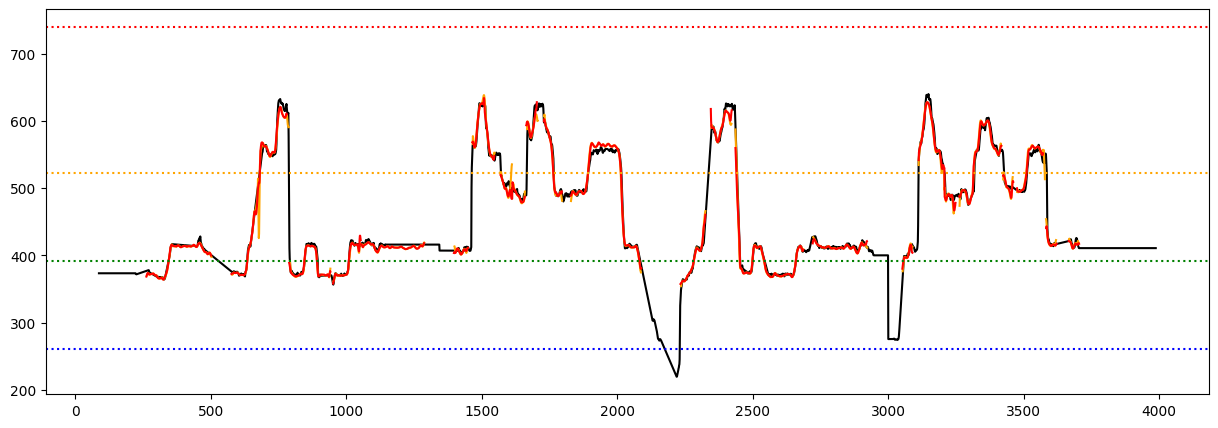

In [6]:
#f0_gen,_=get_pitch_crepe(*vocoder.wav2spec(wav_gen),hparams,threshold=0.05)
%matplotlib inline
f0_gen,_=get_pitch_parselmouth(*svc_model.vocoder.wav2spec(wav_gen),hparams)
f0_tst[f0_tst==0]=np.nan#ground truth f0
f0_pred[f0_pred==0]=np.nan#f0 pe predicted
f0_gen[f0_gen==0]=np.nan#f0 generated
fig=plt.figure(figsize=[15,5])
plt.plot(np.arange(0,len(f0_tst)),f0_tst,color='black')
plt.plot(np.arange(0,len(f0_pred)),f0_pred,color='orange')
plt.plot(np.arange(0,len(f0_gen)),f0_gen,color='red')
plt.axhline(librosa.note_to_hz('C4'),ls=":",c="blue")
plt.axhline(librosa.note_to_hz('G4'),ls=":",c="green")
plt.axhline(librosa.note_to_hz('C5'),ls=":",c="orange")
plt.axhline(librosa.note_to_hz('F#5'),ls=":",c="red")
#plt.axhline(librosa.note_to_hz('A#5'),ls=":",c="black")
plt.show()